# Brain MRI Segmentation
***Predict Brain Tissue Segmentation Masks from Brain MRI Scans***

## Contents

1. [Background](#Background)
1. [Exploratory Data Analyis & Pre-processing](#Exploratory-Data-Analysis-&-Pre-processing)
1. [Train Models on Sagemaker](#Train-Models-on-SageMaker)
1. [Inference Endpoints](#Inference-Endpoints)
1. [Model Evaluation](#Model-Evaluation)
1. [Extensions](#Extensions)

## Background

This notebook shows how to apply image segmentation algorithms to medical imaging use-cases in a simple, streamlined way using Amazon SageMaker. Specifically, we'll be using Apache MXNet to train a convolutional neural network for semantic segmentation on SageMaker using the "Bring Your Own Script" paradigm. Put simply, the goal of semantic segmentation is to make classifications on an image at the pixel-level, producing a classification "mask." We will train two networks, U-Net and ENet. We'll show how to deploy these models to inference endpoints, both in the cloud on Amazon SageMaker and at the edge using AWS GreenGrass.

### Use-case

Medical imaging techniques allow medical professionals to see inside the human body, but more often than not the professional needs precise segmentation of the tissues within the image for analytical procedures and inferences. This is particular relevant in use-cases where volumetric and surface analysis are key to derive insights from the raw imaging, such as assessing the cardivascular health of a patient. Typically, this segmentation is done manually by medical professionals, and is very time consuming. Recently, convolutional neural networks have been shown to be highly performant at this task, and in this notebook we'll train two such networks to automatically segment brain tissue from MRI images.

### CNN Architectures

In this notebook, we apply two models to the task of brain tissue segmentation:
* **U-Net**: Introduced in the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597), this network was originally used for medical-imaging use-cases but has since proven to be reliable in generic segmentation domains. Due to it's architectural and conceptual simplicity, its often used as a baseline.
* **ENet**: Introduced in the paper [ENet: A Deep Neural Network Architecture for Real-Time Semantic Segmentation](https://arxiv.org/abs/1606.02147), ENet is designed to be low-latency and to operate in environments with low compute capacity (e.g. edge devices). Compared to existing architectures, ENet optimizes for processing time over accuracy.

### Dataset

In this notebook, we'll be using Brain MRI data from the [Open Access Series of Imaging Studies (OASIS)](http://www.oasis-brains.org/). This project offers a wealth of neuroimaging datasets; we'll be looking at a small subset of cross-sectional brain MRIs.

OASIS-1: Cross-sectional MRI Data in Young, Middle Aged, Nondemented and Demented Older Adults. In this dataset, there are 434 MR sessions conducted from 416 subjects

For each subject, a number of images are provided, including: 
- 1) 3-4 images corresponding to multiple repetitions of the same structural protocol within a single session to increase signal-to-noise, 
- 2) an average image that is a motion-corrected coregistered average of all available data, 
- 3) a gain-field corrected atlas- registered image to the 1988 atlas space of Talairach and Tournoux (Buckner et al., 2004), 
- 4) a masked version of the atlas-registered image in which all non-brain voxels have been assigned an intensity value of 0, and 5) a grey/white/CSF segmented image 


**Note:** You need to request access on the OASIS site to get the data. In this tutorial, I'll be using the <tt>disc1.tar.gz</tt> file from the [OASIS-1](http://www.oasis-brains.org/#data) data set.

## Exploratory Data Analysis & Pre-processing

In this section, we'll visualize the data and pre-process it for training a segmentation network. Once completed, we'll put the pre-processed data on S3 for SageMaker to use during model training.

### Setup

We'll start by importing the libraries necessary to perform the data visualization and pre-processing.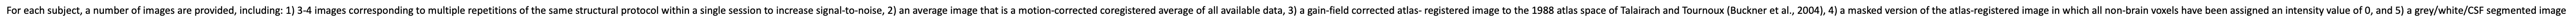

In [2]:
import numpy as np
from PIL import Image
import boto3
import os
from glob import glob
import imageio
from sklearn.model_selection import train_test_split
import time
import urllib
import tarfile
import shutil
import json
import matplotlib.pyplot as plt
%matplotlib inline

from utils.utils import *

### Obtain the environment variables

In [3]:
import sagemaker 
sess = sagemaker.Session()
bucket = sess.default_bucket() 
bucket

'sagemaker-us-east-1-741261399688'

### Download & Extract
Next, we're going to download the compressed data file locally and extract it to our data directory. I've put the <tt>disc1.tar.gx</tt> file in S3 and will download it from there.

I've left the data directory up to you, because depending on your instance type you may or may not have the disk space to download and extract this data set. Some options:
* Download data to the shared memory at <tt>/dev/shm</tt> if you have enough storage capacity there. Data saved here is not persistent, but we're only pre-processing and putting data on S3.
* [Mount an Elastic File System to this instance.](https://aws.amazon.com/blogs/machine-learning/mount-an-efs-file-system-to-an-amazon-sagemaker-notebook-with-lifecycle-configurations/) This is useful if you want your data to persist in a file system accessible by your instance.

In [4]:
data_bucket = bucket # or <YOUR-S3-BUCKET>
data_prefix = 'DICOM/oasis_cross-sectional_disc1.tar' # or <YOUR-S3-PREFIX>
data_dir = './data'   #or <YOUR-DATA-DIR> in  sagemaker 

def create_dir_if_not_exist(d):
    if not os.path.exists(d):
        os.mkdir(d) 

In [6]:
## create a local folder
create_dir_if_not_exist(os.path.join(data_dir, 'brain_mri'))
## download the files from s3 to local folder
boto3.client('s3').download_file(
    Bucket=data_bucket,
    Key=data_prefix,
    Filename=os.path.join(data_dir, "brain_mri", "disc1.tar.gz")
)

## extract all the files in the tar zip file
with tarfile.open(os.path.join(data_dir, "brain_mri", "disc1.tar.gz")) as tar:
    tar.extractall(os.path.join(data_dir, 'brain_mri'))

### Visualization

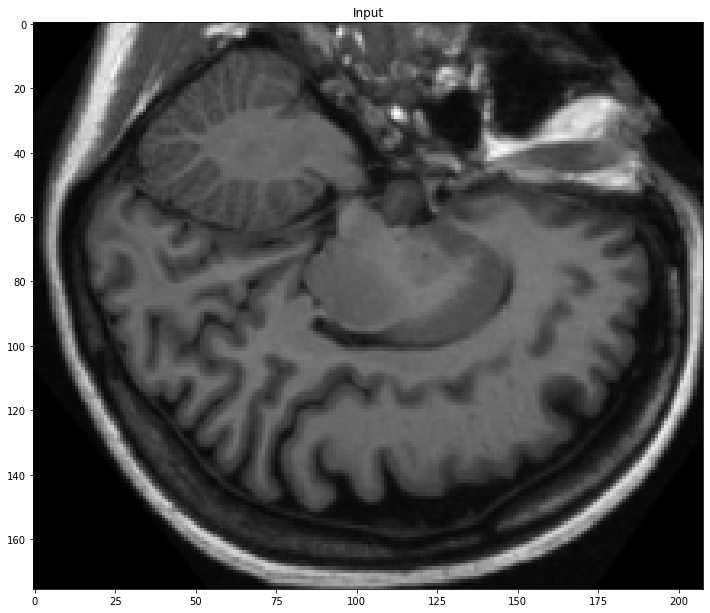

In [8]:
## visulaization for input image 
image = np.fromfile(
    open(os.path.join(data_dir, 'brain_mri','disc1','OAS1_0002_MR1','PROCESSED','MPRAGE','T88_111','OAS1_0002_MR1_mpr_n4_anon_111_t88_gfc.img'), 'rb'),
    np.dtype('>u2')).reshape((176, 208, 176))

plt.figure(figsize=(12, 12))
plt.title('Input')
plt.imshow(image[:, :, 101], cmap=plt.cm.gray)

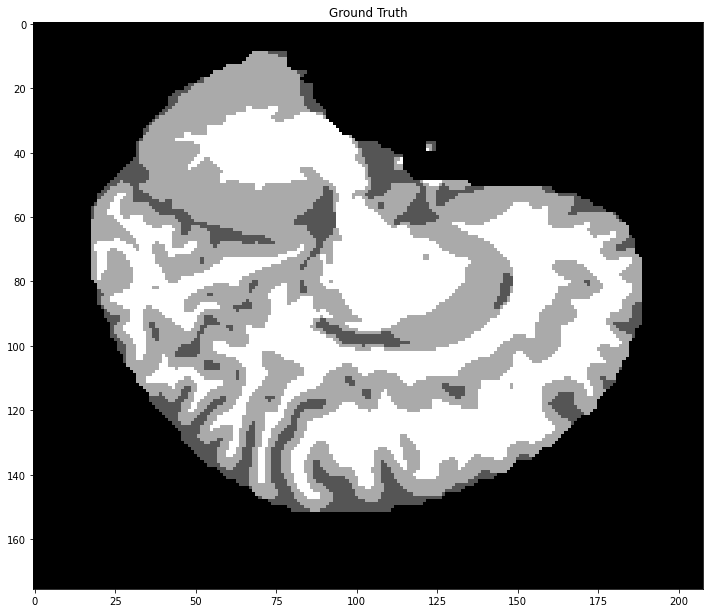

In [9]:
## visulaization for mask image 

segmentation = np.fromfile(
    open(os.path.join(data_dir, 'brain_mri','disc1','OAS1_0002_MR1','FSL_SEG','OAS1_0002_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg.img'), 'rb'),
    np.dtype('>u2')).reshape((176, 208, 88))

plt.figure(figsize=(12, 12))
plt.title('Ground Truth')
plt.imshow(segmentation[:, :, 50], cmap=plt.cm.gray)

### Preprocess the image
Now that we've seen the data, we need to pre-process it to train our network on it. 

During preprocess, we will 1) reshape the images, 2) standadize and 3) save them into png format for faster training. 

First, we're going to split the data into a training and validation set (80/20) **by patient**. This is important to remove any possibility of **data leakage**; neighboring brain MRI slices will correlate and splitting by patient ensures clean validation.

In [25]:
#images = glob(os.path.join(data_dir, 'brain_mri','disc1','*','*','*','*','*t88_gfc.img'))
masks = glob(os.path.join(data_dir, 'brain_mri','disc1','*','*','*t88_masked_gfc_fseg.img'))
len(masks)

39

In [27]:
#images = glob(os.path.join(data_dir, 'brain_mri','disc1','*','*','*','*','*','*t88_gfc.img'))
images = glob(os.path.join(data_dir, 'brain_mri','disc1','*','*','*','*','*t88_gfc.img'))
masks = glob(os.path.join(data_dir, 'brain_mri','disc1','*','*','*t88_masked_gfc_fseg.img'))
images.sort()
masks.sort()
train_images, validation_images, train_masks, validation_masks = train_test_split(
images, masks, test_size=0.2, random_state=1984)

In [30]:
len(validation_images)

8

Next, we're going to load each image and mask slice into memory, pre-process them, and save them to disk as individual image files into respective training and validation directories.

In [6]:
processed_data_dir = os.path.join(data_dir, 'brain_mri', 'data')
train_dir = os.path.join(processed_data_dir, 'train')
validation_dir = os.path.join(processed_data_dir, 'validation')

create_dir_if_not_exist(processed_data_dir)
create_dir_if_not_exist(train_dir)
create_dir_if_not_exist(validation_dir)

In order to pre-process the MRI images, we need to convert them from their native format to arrays that we can save as png images. 

The raw MRI arrays have values that represent radiological intensities. These have a far wider range than pixel intensities, and are loaded into memory as uint16. Upon saving the slices as png's, the data is scaled to fall on the \[0,255\] range of uint8.

**Note**: This scaling can result in differences between tissue pixel distributions from image to image, but this doesn't prove to be a problem.

In [32]:
process_mris(train_images, train_dir)
process_mris(validation_images, validation_dir)

Lossy conversion from >u2 to uint8. Range [0, 1352]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2388]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2199]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2276]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2324]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2650]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2926]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2970]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2932]. Con

./data/brain_mri/disc1/OAS1_0007_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0007_MR1_mpr_n3_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 2669]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2627]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2792]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2809]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2884]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3025]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3317]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3826]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3817]. Con

./data/brain_mri/disc1/OAS1_0042_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0042_MR1_mpr_n4_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 3165]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3685]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3842]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3502]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3510]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3155]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3086]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3213]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3166]. Con

./data/brain_mri/disc1/OAS1_0029_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0029_MR1_mpr_n4_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 3504]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3339]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3251]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3232]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3232]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3350]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3372]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3409]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3441]. Con

./data/brain_mri/disc1/OAS1_0039_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0039_MR1_mpr_n3_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 3085]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3219]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3222]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3102]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3127]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3073]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3476]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3570]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3476]. Con

./data/brain_mri/disc1/OAS1_0035_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0035_MR1_mpr_n4_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 3685]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3591]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3654]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3682]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3436]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3502]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3624]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3472]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3817]. Con

./data/brain_mri/disc1/OAS1_0015_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0015_MR1_mpr_n3_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 3275]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3107]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3150]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3192]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3244]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3105]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3285]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3224]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3255]. Con

./data/brain_mri/disc1/OAS1_0032_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0032_MR1_mpr_n4_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 3548]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3496]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3585]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3838]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3636]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3659]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 4205]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3411]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3335]. Con

./data/brain_mri/disc1/OAS1_0001_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 3696]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3524]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3601]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3642]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3838]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3797]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3838]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3676]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3818]. Con

./data/brain_mri/disc1/OAS1_0037_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0037_MR1_mpr_n4_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 3032]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2628]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2678]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2698]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2732]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2739]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2827]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2805]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2894]. Con

./data/brain_mri/disc1/OAS1_0021_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0021_MR1_mpr_n4_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 3168]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3153]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3104]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3148]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3201]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3124]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3089]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3382]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3631]. Con

./data/brain_mri/disc1/OAS1_0019_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0019_MR1_mpr_n4_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 3018]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3138]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3236]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3195]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3301]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3171]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3172]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3133]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3162]. Con

./data/brain_mri/disc1/OAS1_0013_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0013_MR1_mpr_n4_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 3185]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3179]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3128]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3306]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3364]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3020]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2910]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3646]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3867]. Con

./data/brain_mri/disc1/OAS1_0014_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0014_MR1_mpr_n4_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 2728]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2818]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2862]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2794]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2972]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2782]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3020]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2916]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2919]. Con

./data/brain_mri/disc1/OAS1_0022_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0022_MR1_mpr_n4_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 2863]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2886]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3007]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3037]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3136]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3083]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3018]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3348]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3300]. Con

./data/brain_mri/disc1/OAS1_0026_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0026_MR1_mpr_n3_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 2743]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2733]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2784]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2793]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2808]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2797]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2761]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2849]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2800]. Con

./data/brain_mri/disc1/OAS1_0025_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0025_MR1_mpr_n4_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 2657]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2671]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2603]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2660]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2772]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2632]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2713]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2876]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2741]. Con

./data/brain_mri/disc1/OAS1_0009_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0009_MR1_mpr_n4_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 2638]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2325]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2351]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3358]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3029]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3370]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2546]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2610]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2497]. Con

./data/brain_mri/disc1/OAS1_0006_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0006_MR1_mpr_n4_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 2601]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2613]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2651]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2656]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3027]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3036]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2931]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2919]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2729]. Con

./data/brain_mri/disc1/OAS1_0030_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0030_MR1_mpr_n4_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 3293]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3829]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3662]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3769]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3431]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3534]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3603]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3954]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3876]. Con

./data/brain_mri/disc1/OAS1_0016_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0016_MR1_mpr_n3_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 3141]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3354]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3279]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3273]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3411]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3452]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3537]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3344]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3546]. Con

./data/brain_mri/disc1/OAS1_0002_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0002_MR1_mpr_n4_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 2757]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2835]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2722]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2838]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2860]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2798]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2891]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2862]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2859]. Con

./data/brain_mri/disc1/OAS1_0018_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0018_MR1_mpr_n4_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 2662]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2694]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2901]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2768]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2693]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2594]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2635]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2700]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2663]. Con

./data/brain_mri/disc1/OAS1_0038_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0038_MR1_mpr_n3_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 2676]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2687]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2570]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2642]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2639]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2712]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3001]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3528]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 4025]. Con

./data/brain_mri/disc1/OAS1_0011_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0011_MR1_mpr_n4_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 2754]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2797]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2771]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2849]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2778]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2713]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2761]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2756]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2915]. Con

./data/brain_mri/disc1/OAS1_0003_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0003_MR1_mpr_n4_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 3063]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3070]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3240]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3252]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3297]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3300]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3382]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3573]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3588]. Con

./data/brain_mri/disc1/OAS1_0023_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0023_MR1_mpr_n4_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 3211]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3626]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3678]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 4209]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 4049]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3306]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3314]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3279]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3309]. Con

./data/brain_mri/disc1/OAS1_0012_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0012_MR1_mpr_n4_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 2603]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2638]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2616]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2678]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2765]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2721]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3377]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3381]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3141]. Con

./data/brain_mri/disc1/OAS1_0040_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0040_MR1_mpr_n4_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 2863]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2845]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2924]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2957]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3013]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2918]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3065]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2966]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3011]. Con

./data/brain_mri/disc1/OAS1_0010_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0010_MR1_mpr_n4_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 3614]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3576]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3728]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3770]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3865]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3727]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3823]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3852]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3962]. Con

./data/brain_mri/disc1/OAS1_0028_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0028_MR1_mpr_n4_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 3139]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3172]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3299]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3351]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3393]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3536]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3569]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3691]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3680]. Con

./data/brain_mri/disc1/OAS1_0031_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0031_MR1_mpr_n4_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 3305]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3693]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3402]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3732]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3707]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3570]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3435]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3515]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3551]. Con

./data/brain_mri/disc1/OAS1_0020_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0020_MR1_mpr_n3_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 2957]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3067]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3190]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3144]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3103]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3022]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2945]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3327]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3646]. Con

./data/brain_mri/disc1/OAS1_0027_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0027_MR1_mpr_n4_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 2940]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2893]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2949]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3002]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3041]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3092]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3003]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3027]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3845]. Con

./data/brain_mri/disc1/OAS1_0017_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0017_MR1_mpr_n4_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 2657]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2699]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2918]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2882]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3187]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3247]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3193]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3272]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3189]. Con

./data/brain_mri/disc1/OAS1_0034_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0034_MR1_mpr_n3_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 3106]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3145]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3230]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3203]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3196]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3194]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3415]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3288]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3249]. Con

./data/brain_mri/disc1/OAS1_0041_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0041_MR1_mpr_n4_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 2981]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2918]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2937]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2953]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2983]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3053]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3007]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3092]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3305]. Con

./data/brain_mri/disc1/OAS1_0004_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0004_MR1_mpr_n4_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 2668]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2896]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2808]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2933]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2849]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2966]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3146]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3003]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3128]. Con

./data/brain_mri/disc1/OAS1_0033_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0033_MR1_mpr_n4_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 2752]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2870]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2946]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2952]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3027]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3162]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3133]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3284]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3013]. Con

./data/brain_mri/disc1/OAS1_0005_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0005_MR1_mpr_n4_anon_111_t88_gfc.img


Lossy conversion from >u2 to uint8. Range [0, 2882]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2996]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2834]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2780]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2684]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 2961]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3159]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3667]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from >u2 to uint8. Range [0, 3635]. Con

In [33]:
process_labels(train_masks, train_dir)
process_labels(validation_masks, validation_dir)

Note that in both steps, we saved the files under a specific naming convention. This is so the I/O iterators we'll use to load the data know how to pair the images and masks.

### Sample, Distributed Sets

Now that we've pre-processed our data, we're going to make two additional data sets from this:
* Sample data for testing our algorithm locally
* 50-50 split of the training data for distributed training

To do this, we'll grab all image, mask pairs.

In [34]:
train_pairs = [(img, img.split('.')[0]+'_mask.png')
               for img in os.listdir(train_dir) if 'mask' not in img]
validation_pairs = [(img, img.split('.')[0]+'_mask.png')
                    for img in os.listdir(validation_dir) if 'mask' not in img]

In [7]:
tar_gz_dir = os.path.join(data_dir, 'tar_gz')
tar_gz_train_dir = os.path.join(tar_gz_dir, "train")
tar_gz_validation_dir = os.path.join(tar_gz_dir, "validation")

with tarfile.open(os.path.join(tar_gz_train_dir, "train.tar.gz"), "w:gz") as tar:
    tar.add(train_dir, arcname='')
with tarfile.open(os.path.join(tar_gz_validation_dir, "validation.tar.gz"), "w:gz") as tar:
    tar.add(validation_dir, arcname='')

## Training and Tuning 

## Train Models on SageMaker

### Setup

We'll begin by importing the SageMaker python SDK. We're going to define:
* Session object that provides convenience methods within the context of SageMaker and our own account.
* SageMaker role ARN used to delegate permissions to the training and hosting service. We need this so these services can access the S3 buckets where your data and model is stored.

We'll also import the sagemaker <tt>MXNet</tt> estimator object. This object references default containers that AWS provides, and users provide only entry points and supporting code. This is known as "Bring Your Own Script."

In [35]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.mxnet import MXNet

sagemaker_session = sagemaker.Session()
role = get_execution_role()

### Upload data

Next, we're going to upload the pre-processed data to S3 using the <tt>upload_data</tt> method to put the objects in a default SageMaker bucket. We're going to pass the parent directory containing the compressed files to the method, which syncs the child tree to the bucket.

In [ ]:
prefix = 'brain-segmentation-tar-gz'
data_bucket = sagemaker_session.upload_data(path=tar_gz_dir, key_prefix=prefix)
print(tar_gz_dir)
print(data_bucket)

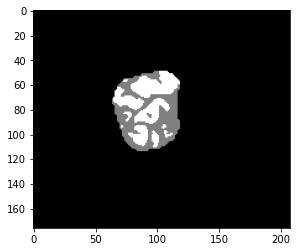

In [42]:
import numpy as np
from PIL import Image

test_mask = np.array(Image.open(os.path.join(
    validation_dir, 'OAS1_0004_MR1_mpr_n4_anon_111_t88_11_mask.png')))[np.newaxis, np.newaxis, :]
plt.imshow(test_mask[0][0], cmap=plt.cm.gray)